# Visualizations

This is a notebook that is intended to be used for debugging and model tuning during development. It provides some basic visualizations that are drawn from the results of running [1] the `train.py` file and [2] the `evaluation.py` file.

In [1]:
from utils import get_run_id
import mlflow

#mlflow.set_tracking_uri() # <- Set it up if not default
client = mlflow.MlflowClient()

dataset = "system_1"

# Get a model to work with
run_id = get_run_id("-1", f"{dataset}_training")

# Define output path
art_uri = mlflow.get_run(run_id).info.artifact_uri

## Losses During Training

Here we print the train/validation losses during the training of the model.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set(rc={'figure.figsize':(14.7,5.27)})

sns.set(rc={"grid.color": "#595d61", 'axes.facecolor':'#3d4144'})
cust_cols = {'total_train' : '#E91E63', 'total_val' : '#60C689', 'forecast' : 'yellow', 'recon' : '#B767e7'}

In [3]:
import numpy as np

def vals_from_metric(run_id, key):
    metrics = client.get_metric_history(run_id=run_id, key=key)
    vals = [m.value for m in metrics]
    return np.asarray(vals)

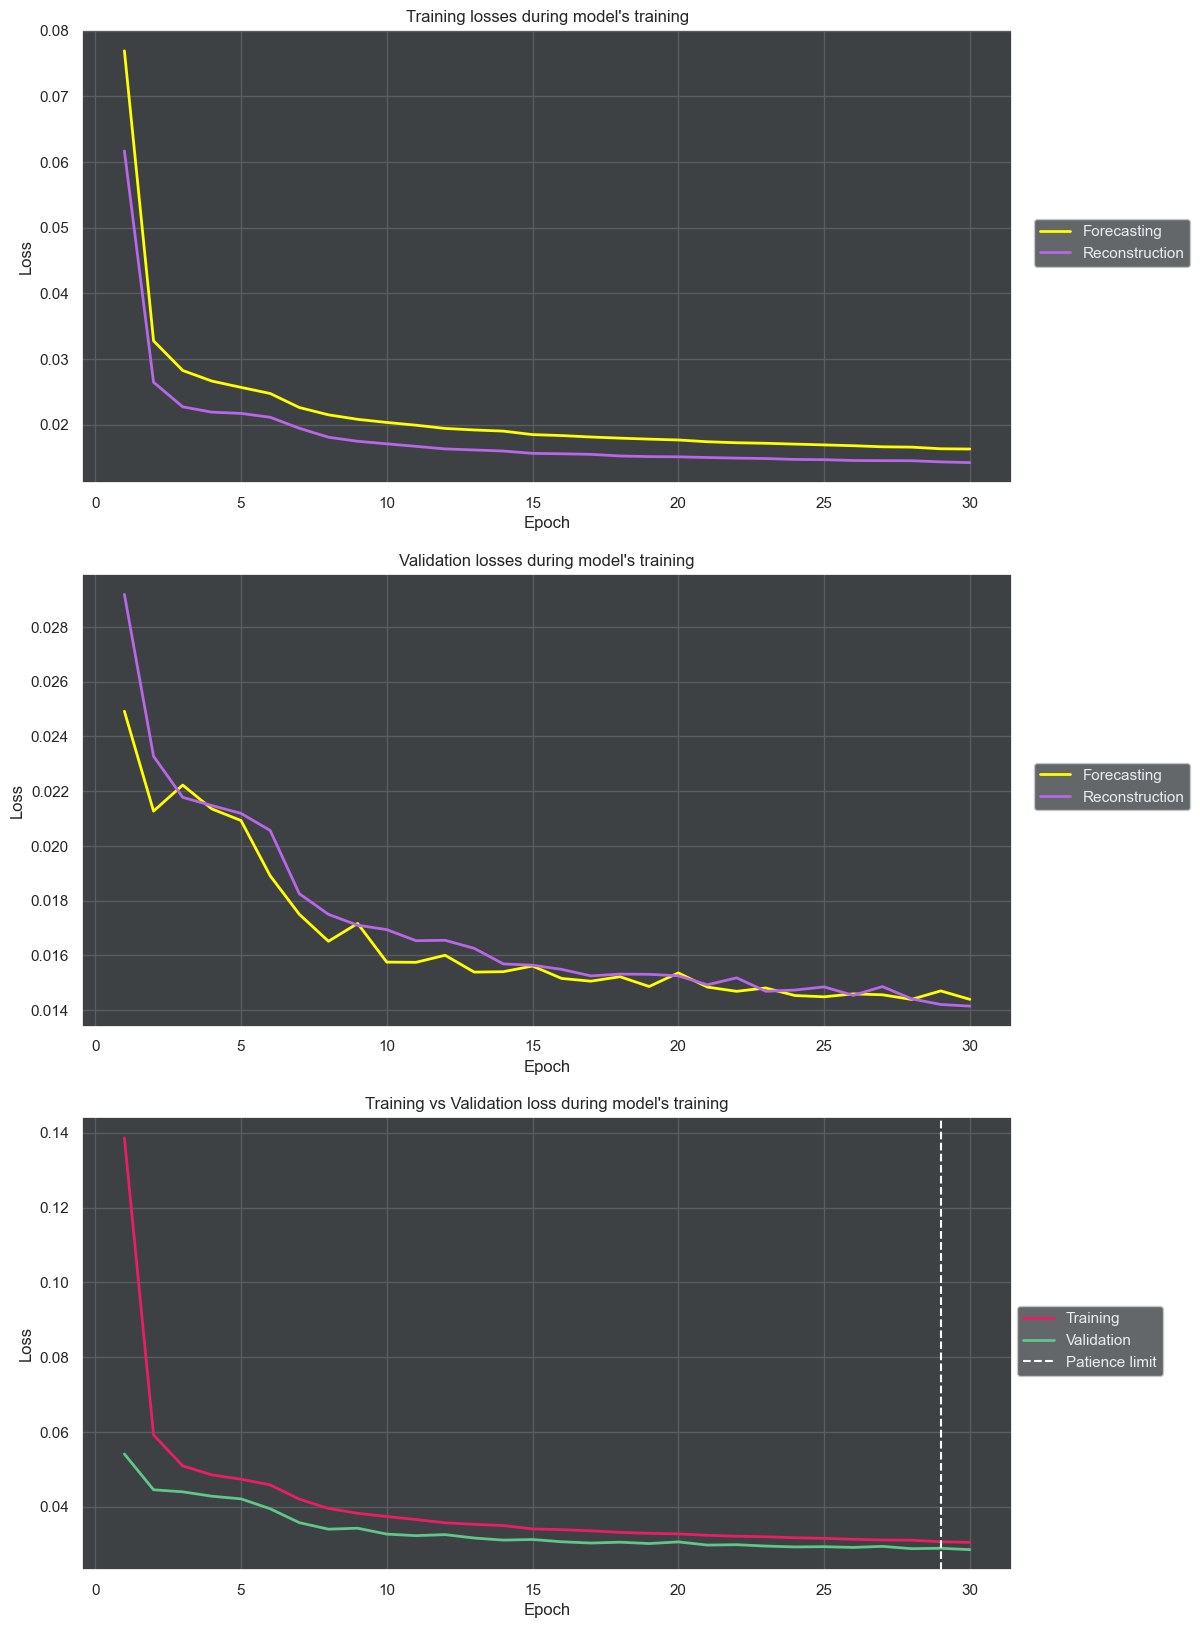

In [4]:
# load the relevant data
fc_train = vals_from_metric(run_id, "train_fc_loss")
recon_train = vals_from_metric(run_id, "train_rc_loss")

fc_val = vals_from_metric(run_id, "val_fc_loss")
recon_val = vals_from_metric(run_id, "val_rc_loss")

tot_train = vals_from_metric(run_id, "total_train_loss")
tot_val = vals_from_metric(run_id, "total_val_loss")

epochs = list(range(1,fc_train.shape[0]+1))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,20))

axes[0].plot(epochs, fc_train, color=cust_cols['forecast'], linestyle='-', linewidth=2.0, label='Forecasting')
axes[0].plot(epochs, recon_train, color=cust_cols['recon'], linestyle='-', linewidth=2.0, label='Reconstruction')
axes[0].legend(labelcolor='#E9edf1', bbox_to_anchor=(1.20, 0.6))
axes[0].set_title("Training losses during model's training")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

axes[1].plot(epochs, fc_val, color=cust_cols['forecast'], linestyle='-', linewidth=2.0, label='Forecasting')
axes[1].plot(epochs, recon_val, color=cust_cols['recon'], linestyle='-', linewidth=2.0, label='Reconstruction')
axes[1].legend(labelcolor='#E9edf1', bbox_to_anchor=(1.20, 0.6))
axes[1].set_title("Validation losses during model's training")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

axes[2].plot(epochs, tot_train, color=cust_cols['total_train'], linestyle='-', linewidth=2.0, label='Training')
axes[2].plot(epochs, tot_val, color=cust_cols['total_val'], linestyle='-', linewidth=2.0, label='Validation')
axes[2].axvline(tot_val.argmin(), color='white', linestyle='--', label='Patience limit')
axes[2].legend(labelcolor='#E9edf1', bbox_to_anchor=(1.17, 0.6))
axes[2].set_title("Training vs Validation loss during model's training")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")

plt.show()

## Anomaly Scores

Here we load the anomaly scores as calculated by the evaluation module and examine peaks based on different thresholds. We also draw anomalies based on scores + thresholds and compare with the ground truth labels.

In [5]:
import os
import json
from utils import json_to_numpy, PA, anoms_to_indices, create_anom_range

# Load scores
scores = json_to_numpy(art_uri+"/eval_scores.json")

# Load thresholds as dict
thresholds = mlflow.artifacts.load_dict(art_uri+"/thresholds.json")
    
# load ground truth
truth = np.loadtxt(os.path.join(f"datasets/{dataset}", "labels.txt"), delimiter=",", dtype=int)

In [6]:
def plot_detailed_scores(scores, labels, threshold):
    
    # Get actual predictions given the scores and threshold
    anoms = np.asarray([0 if score < threshold else 1 for score in scores])
    
    # Perform point-adjustment
    pa_anoms = PA(labels, anoms)
    
    indices = list(range(labels.shape[0]))
    cust_cols = {'scores' : '#B767e7', 'preds' : 'yellow', 'preds-pa' : '#60C689', 'truth' : '#57ACDC'}

    fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15,14), height_ratios=[2.5, 1, 1, 1])
    
    axes[0].plot(indices, scores, linestyle='-', linewidth=1.0, color=cust_cols['scores'], label='Anomaly Scores')
    axes[0].axhline(threshold, color='white', linestyle='--', label='Threshold')
    axes[0].set_title(f'Anomaly Scores for threshold: {threshold:.4f}')
    
    axes[1].plot(indices, anoms, linestyle='-', color=cust_cols['preds'], label='Predicted Anomalies')
    axes[1].set_yticklabels([])
    
    axes[2].plot(indices, pa_anoms, linestyle='-', color=cust_cols['preds-pa'], label='Adjusted Anomalies')
    axes[2].set_yticklabels([])
    
    axes[3].plot(indices, labels, linestyle='-', color=cust_cols['truth'], label='Ground Truth')
    axes[3].set_yticklabels([])
    
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, labelcolor='#E9edf1', bbox_to_anchor=(1.05, 0.51))
    
    plt.show()

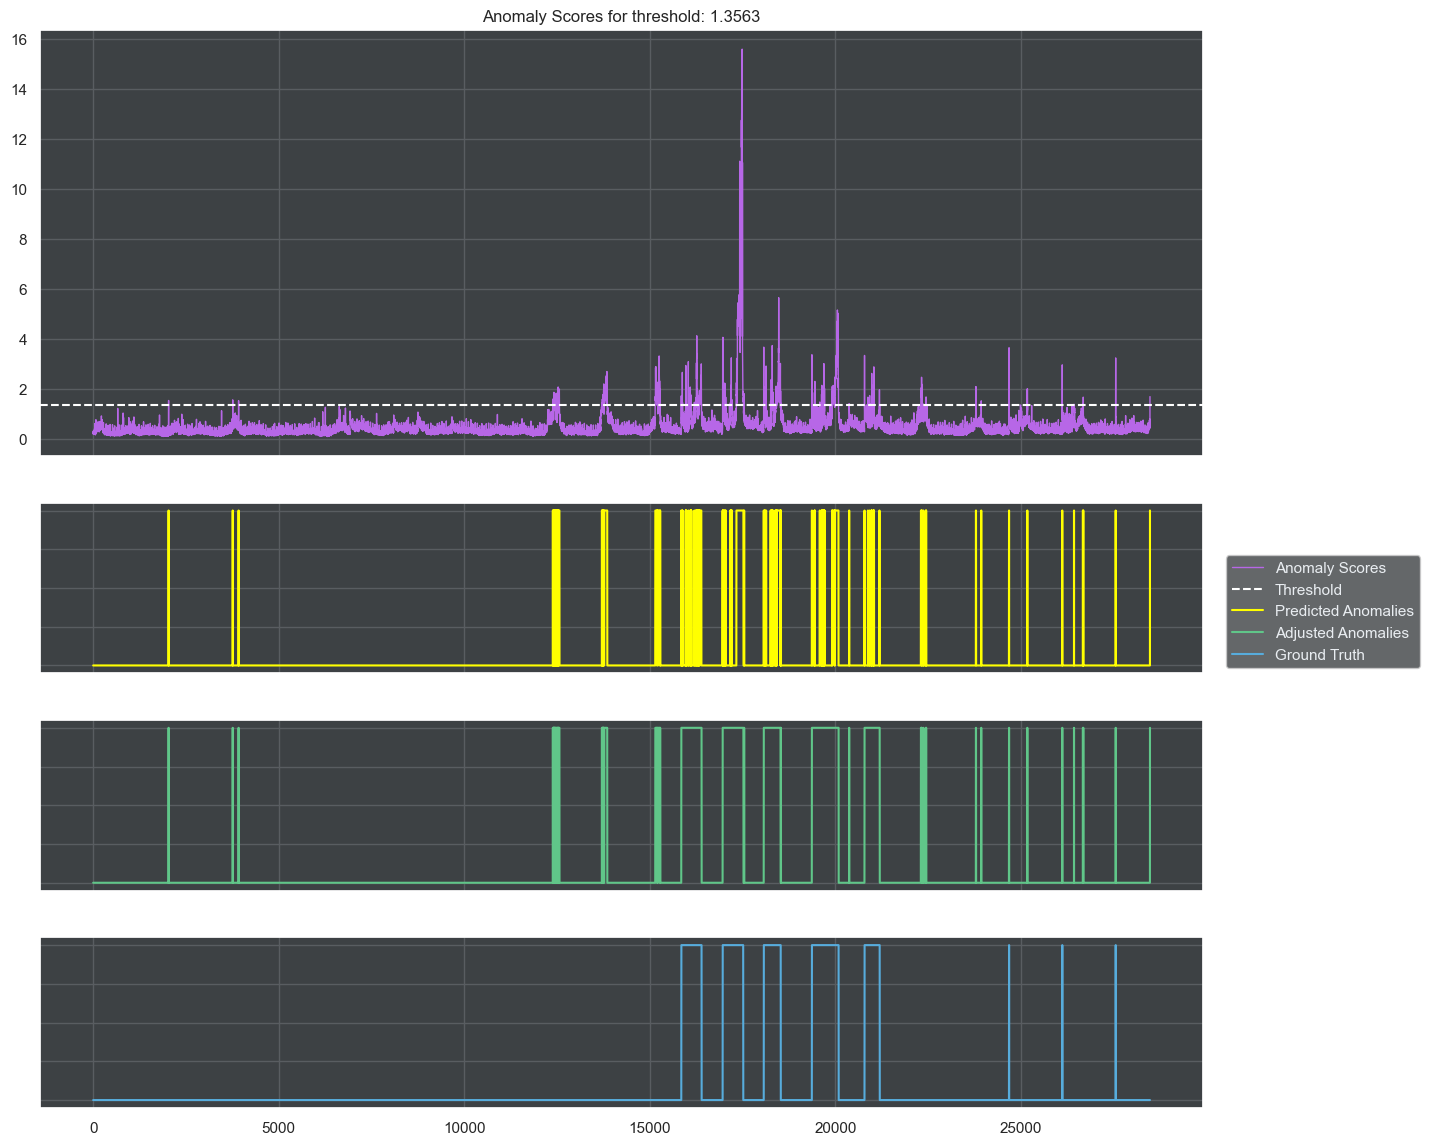

In [7]:
e, pot, bf, pa_bf = thresholds.values()

plot_detailed_scores(scores, truth, e)

In [8]:
def plot_scores(scores, labels, threshold):
    # Get actual predictions given the scores and threshold
    anoms = np.asarray([0 if score < threshold else 1 for score in scores])
    # Perform point-adjustment
    pa_anoms = PA(labels, anoms)
    # Get correct predictions
    found = labels*pa_anoms 
    # Make ranges
    inds, xs = anoms_to_indices(found)
    found = create_anom_range(xs, inds)
    
    indices = list(range(labels.shape[0]))
    cust_cols = {'scores' : '#B767e7', 'anoms' : '#E91E63'}

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    
    ax.plot(indices, scores, linestyle='-', linewidth=1.0, color=cust_cols['scores'], label='Anomaly Scores')
    ax.axhline(threshold, color='white', linestyle='--', label='Threshold')
    # plot correctly identified anomalies
    for idx, (start, end) in enumerate(found):
        if idx==0:
            ax.axvspan(start, end, facecolor=cust_cols['anoms'], alpha=0.2, label='Identified Anomalies')
        else:
            ax.axvspan(start, end, facecolor=cust_cols['anoms'], alpha=0.2)
    ax.set_title(f'Anomaly Scores for threshold: {threshold:.4f}')
    
    plt.legend(labelcolor='#E9edf1', loc='best')
    plt.show()

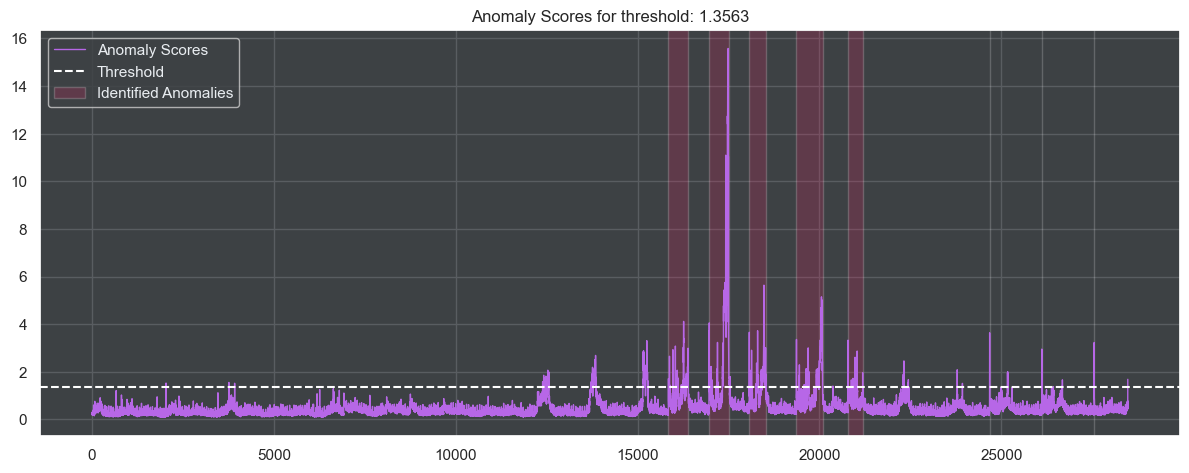

In [9]:
plot_scores(scores, truth, e)

## Feature-level Predictions

Here we provide more fine-grained information regarding the results, by visualizing per-feature scores and predictions.

In [10]:
import pandas as pd

df_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="per_feat_scores.pkl")
df = pd.read_pickle(df_path)

In [11]:
def plot_feat_details(df, feat, labels, start=0, end=None):
    fcs = df[f'FC_{feat}'].values[start:end]
    recons = df[f'RECON_{feat}'].values[start:end]
    actual = df[f'TRUE_{feat}'].values[start:end]
    scores = df[f'SCORE_{feat}'].values[start:end]
    
    # Make ranges for actual anomalies
    inds, xs = anoms_to_indices(labels)
    anoms = create_anom_range(xs, inds)
    
    indices = list(range(labels.shape[0]))[start:end]
    cust_cols = {'scores' : '#B767e7', 'fcs' : '#60C689', 'recons' : 'yellow', 'actual' : '#57ACDC', 'anoms' : '#E91E63'}

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,6))
    
    axes[0].plot(indices, fcs, linestyle='-', linewidth=1.0, color=cust_cols['fcs'], label='Forecasting')
    axes[0].plot(indices, recons, linestyle='-', linewidth=1.0, color=cust_cols['recons'], label='Reconstruction')
    axes[0].plot(indices, actual, linestyle='-', linewidth=1.0, color=cust_cols['actual'], label='Measured')
    # plot ground truth anomalies
    ct = 0
    for (a, b) in anoms:
        if a >= start and b <= end:
            if ct==0:
                axes[0].axvspan(a, b, facecolor=cust_cols['anoms'], alpha=0.2, label='Anomalies')
                ct += 1
            else:
                axes[0].axvspan(a, b, facecolor=cust_cols['anoms'], alpha=0.2)
            
    axes[0].set_title(f'Predictions and Measurements for Feature No. {feat+1}')
    axes[0].legend(labelcolor='#E9edf1', loc='upper left')
    
    axes[1].plot(indices, scores, linestyle='-', linewidth=1.0, color=cust_cols['scores'], label='Scores')
    # plot ground truth anomalies
    ct = 0
    for (a, b) in anoms:
        if a >= start and b <= end:
            if ct==0:
                axes[1].axvspan(a, b, facecolor=cust_cols['anoms'], alpha=0.2, label='Anomalies')
                ct += 1
            else:
                axes[1].axvspan(a, b, facecolor=cust_cols['anoms'], alpha=0.2)
            
    axes[1].set_title(f'Anomaly Scores for Feature No. {feat+1}')
    axes[1].legend(labelcolor='#E9edf1', loc='best')
    
    plt.show()

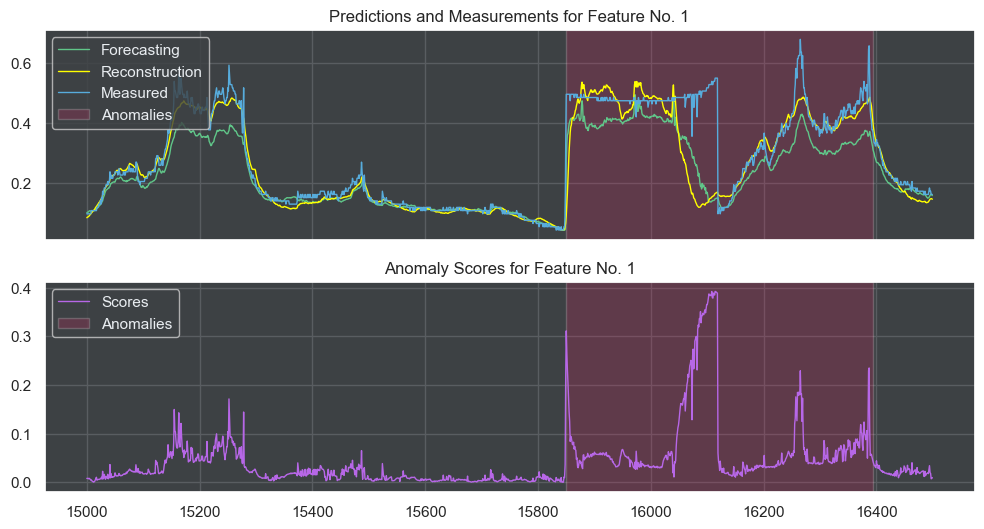

In [12]:
plot_feat_details(df, 0, truth, 15000, 16500)